#Downloading data from kaggle:

In [123]:
!mkdir ~/.kaggle/

In [124]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [125]:
!ls -a ~/.kaggle/

.  ..  kaggle.json


In [126]:
!kaggle datasets download snap/amazon-fine-food-reviews -f Reviews.csv

 94% 108M/115M [00:01<00:00, 90.8MB/s]
100% 115M/115M [00:01<00:00, 109MB/s] 


In [127]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from bs4 import BeautifulSoup
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import os

#Preprocessing Data

In [128]:
#loading 100000 data becoz of resources limitation
data = pd.read_csv("/content/Reviews.csv.zip")

In [129]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

**Objective:**<br>
Given a review determine weather review is +ve (rating 4 or 5) or -ve(rating 1 or 2)


<h2>Exploratory data analysis</h2>

In [130]:
#dropping all the rows with score = 3
data = data[data["Score"] != 3]

<h3>

<h3>Data deduplication</h3>

First the same user at the same time can't review with the same text on different products but looking below we can say this is the case since look at UserId '#oc-R11D9D7SHXIJB9' below:

In [131]:
data[data.duplicated(["UserId", "Time", "Text"])].sort_values(["UserId", "Time"]).head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
180871,180872,B007Y59HVM,#oc-R115TNMSPFT9I7,Breyton,2,3,2,1331510400,"""Green"" K-cup packaging sacrifices flavor",Overall its just OK when considering the price...
455533,455534,B005HG9ERW,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
496893,496894,B005HG9ET0,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
181210,181211,B007Y59HVM,#oc-R11DNU2NBKQ23Z,Kim Cieszykowski,0,2,1,1348531200,Terrible coffee,This coffee is horrible and unfortunately not ...
455359,455360,B005HG9ERW,#oc-R11O5J5ZVQE25C,Penguin Chick,0,0,5,1346889600,Refreshing!,This will be the bottle that you grab from the...


Actually, it's not the error by amazon but instead amazon adding the same review on the same product but with some different flavours and with different ProductId.

In [132]:
#dropping duplicates
new_data = data.drop_duplicates(["UserId", "ProfileName", "Time", "Text"])

In [133]:
#Checking to see how much % of data still remains
(new_data['Id'].size*1.0)/(data['Id'].size*1.0)*100

69.25890143662969

Also HelpfulnessNumerator can't be greater than HelpfulnessDenominator and so removing those rows:

In [134]:
new_data = new_data[new_data.HelpfulnessNumerator<=new_data.HelpfulnessDenominator]

In [135]:
new_data["Y"] = (new_data["Score"]>3)*1

**Becoz of computing resource limitation dropping rows from class 1 since class 1 is huge than class 0:**

In [136]:
#source https://stackoverflow.com/a/54791022/11437685

#making our dataset balanced by dropping rows from class 1(becoz of resource limitation)
def sampling_k_elements(group, k=57110):
    if len(group) < k:
        return group
    return group.sample(k, random_state=42)

balanced_data = new_data.groupby('Y').apply(sampling_k_elements).reset_index(drop=True)

In [137]:
X = balanced_data["Text"].apply(lambda sent: sent.lower())
Y = balanced_data["Y"]

In [138]:
#balanced dataset
print(X.shape, Y.value_counts(), sep="\n")

(114220,)
1    57110
0    57110
Name: Y, dtype: int64


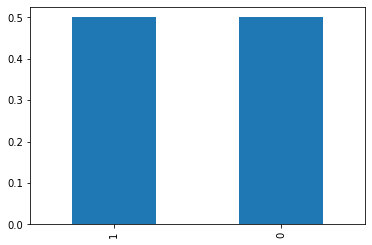

In [139]:
#balaced dataset
(Y.value_counts()/Y.shape[0]).plot(kind='bar')

##Text preprocessing:

In [140]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [141]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [142]:
stpwrds = stopwords.words('english')

#removing some of the words from the stopwords since here these words are very useful for our task
stpwrds.remove("not")
stpwrds.remove("nor")
stpwrds.remove("no")

In [143]:
#removing all the urls since not useful in classificatioin
X = X.apply(lambda sent: re.sub(r"http\S+", "", sent))

#used for just getting text and removing all the html tags
X = X.apply(lambda sent: BeautifulSoup(sent, 'lxml').get_text())

#Decontracting
X = X.apply(decontracted)

#removing words with numbers and then removing extra spaces at start and end
X = X.apply(lambda sent: re.sub("\S*\d\S*", "", sent).strip())

X = X.apply(lambda sent: ' '.join(w for w in sent.split() if w not in stpwrds))

**Apply stemming:**

Here we will do stemming where the inflected words will get reduced to their root form i.e. word stem:

In [144]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [145]:
porter = PorterStemmer()

In [146]:
def stemming(sent):
    #getting actual word from the sent
    tokens = word_tokenize(sent)
    return " ".join(porter.stem(w) for w in tokens)

In [147]:
X = X.apply(stemming)

In [148]:
#printing some random text
print(X[10])

not realli tortilla , flat circular piec bread . fine that want , want tortilla . love tumaro tortilla amazon carri those , healthi , tasti tortilla . not bend well around burrito `` wrap '' either dri . also , although whole grain , not low calori anyth . one tortilla , mind small size , calori gram fat mg sodium . yet , tast dri stale.sinc descript leav last ingredi , finish them . `` contain less follow : calcium propion , fumar acid , aluminum free bake powder , refin odorless tasteless fish oil , gelatin , tocopherol , natur flavor , citric acid , sodium ascorb potassium sorbat . allergen : contain wheat , gluten , soy , odorless tasteless fish oil . `` i not recommend unless look dri , flat circular piec bread plenti calori sodium .


In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42, stratify=Y)

**Saving preprocessed data:**

In [ ]:
# X_train.to_csv("/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/preprocessed_data/X_train.csv", index=False)
# X_test.to_csv("/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/preprocessed_data/X_test.csv", index=False)
# y_train.to_csv("/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/preprocessed_data/y_train.csv", index=False)
# y_test.to_csv("/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/preprocessed_data/y_test.csv", index=False)

**Load preprocessed data:**

In [150]:
# X_train1 = pd.read_csv("/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/preprocessed_data/X_train.csv")["Text"]
# X_test1 = pd.read_csv("/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/preprocessed_data/X_test.csv")["Text"]
y_train = np.array(pd.read_csv("/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/preprocessed_data/y_train.csv")["Y"])
y_test = np.array(pd.read_csv("/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/preprocessed_data/y_test.csv")["Y"])

## Featurization:

### BOW vectorization:

In [182]:
bow = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
X_train_bow = bow.fit_transform(X_train)

In [183]:
X_test_bow = bow.transform(X_test)

In [184]:
#sparse matrix
X_train_bow

<102798x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 3863993 stored elements in Compressed Sparse Row format>

In [185]:
#all the top selected features
print(bow.get_feature_names_out())

['abil' 'abl' 'abl buy' ... 'zevia' 'zico' 'zip']


**Saving preprocessed data:**

In [186]:
# scipy.sparse.save_npz('/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/preprocessed_data/X_train_bow.npz', X_train_bow)
# scipy.sparse.save_npz('/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/preprocessed_data/X_test_bow.npz', X_test_bow)

**Loading preprocessed data:**

In [187]:
X_train_bow = scipy.sparse.load_npz('/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/preprocessed_data/X_train_bow.npz')
X_test_bow = scipy.sparse.load_npz('/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/preprocessed_data/X_test_bow.npz')

**Feature Normalisation**

In [188]:
#using MaxAbsScaler becoz it works with the sparse and we have only +ve data and so similar to MinMaxScaler
scaler_bow = MaxAbsScaler().fit(X_train_bow)

In [189]:
X_train_bow = scaler_bow.transform(X_train_bow)

In [190]:
X_test_bow = scaler_bow.transform(X_test_bow)

**Saving bow and scaler_bow:**

In [179]:
#we will use it later for avoiding data leakage
with open("/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_vectorizer/bow_scaler.pkl", 'wb') as f:
    pickle.dump((bow, scaler_bow), f)

###TFIDF Featurization:

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=10000)
X_train_tfidf = tfidf.fit_transform(X_train)

In [ ]:
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
#a sparse matrix
X_train_tfidf

In [ ]:
#all the top selected features
print(tfidf.get_feature_names_out())

**Saving preprocessed data:**

In [ ]:
# scipy.sparse.save_npz('/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/preprocessed_data/X_train_tfidf.npz', X_train_tfidf)
# scipy.sparse.save_npz('/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/preprocessed_data/X_test_tfidf.npz', X_test_tfidf)

**Loading preprocessed data:**

In [ ]:
X_train_tfidf = scipy.sparse.load_npz('/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/preprocessed_data/X_train_tfidf.npz')
X_test_tfidf = scipy.sparse.load_npz('/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/preprocessed_data/X_test_tfidf.npz')

**Feature Normalisation**

In [ ]:
#using MaxAbsScaler becoz it works with the sparse and we have only +ve data and so similar to MinMaxScaler
scaler_tfidf = MaxAbsScaler().fit(X_train_tfidf)

In [ ]:
X_train_tfidf = scaler_tfidf.transform(X_train_tfidf)

In [ ]:
X_test_tfidf = scaler_tfidf.transform(X_test_tfidf)

### Word2Vec Vectorization:

In [ ]:
# !pip install gdown
#downloading a pretrained model by google
# !gdown --id "https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM"

In [ ]:
from gensim.models import KeyedVectors
import os

#using a pretrained model by google
if os.path.isfile('/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/GoogleNews-vectors-negative300.bin.gz'):
    w2v_model=KeyedVectors.load_word2vec_format('/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/GoogleNews-vectors-negative300.bin.gz', binary=True)

### Avg Word2Vec

In [ ]:
#All the learned vocabulary 
# vocab = w2v_model.key_to_index
vocab = w2v_model.vocab

In [ ]:
#func for avgW2V
def avgW2vec(sent):
    lst_wrds = sent.split(" ")
    #store avgw2v of size 300
    avg_w2v = np.zeros(300,dtype='float64')
    for w in lst_wrds:
        if w in vocab:
            avg_w2v += w2v_model[w]
    n = len(lst_wrds)
    if n != 0: avg_w2v /= n
    else: raise Exception(f"Here len(query) can't be {n}")
    return avg_w2v

#avgW2vec on each sent in X_train
X_train_avgw2v = X_train.apply(avgW2vec)

In [ ]:
#Having some problems of dtype and dims, when directly converting to np array and so first series to list and then list to np array
X_train_avgw2v = X_train_avgw2v.to_list()
X_train_avgw2v = np.array(X_train_avgw2v)

In [ ]:
X_test_avgw2v = X_test.apply(avgW2vec)

In [ ]:
#Having some problems of dtype and dims, when directly converting to np array and so first series to list and then list to np array
X_test_avgw2v = X_test_avgw2v.to_list()
X_test_avgw2v = np.array(X_test_avgw2v)

**Saving preprocessed data:**

In [ ]:
# with open('/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/preprocessed_data/X_train_avgw2v.npz', "wb") as f:
#     np.save(f, X_train_avgw2v)

# with open('/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/preprocessed_data/X_test_avgw2v.npz', "wb") as f:
#     np.save(f, X_test_avgw2v)

**Loading preprocessed data:**

In [ ]:
with open('/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/preprocessed_data/X_train_avgw2v.npz', "rb") as f:
    X_train_avgw2v = np.load(f)

with open('/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/preprocessed_data/X_test_avgw2v.npz', "rb") as f:
    X_test_avgw2v = np.load(f)

**Feature Normalisation**

In [ ]:
scaler_avgw2v = MinMaxScaler().fit(X_train_avgw2v)

In [ ]:
X_train_avgw2v = scaler_avgw2v.transform(X_train_avgw2v)

In [ ]:
X_test_avgw2v = scaler_avgw2v.transform(X_test_avgw2v)

### TFIDF-W2V

In [ ]:
#getting all the feature names used in tfidf for tfidf-w2v
idf_dict = dict(zip(tfidf.get_feature_names_out(), list(tfidf.idf_)))

In [ ]:
from collections import Counter

#func for avgW2V
def tfidfW2V(sent):
    #storing all tfidf of each word for computing total tfidf of a sent
    tfidf_vec = list()
    
    #splitting and counting # of each words in sent
    lst_wrds = sent.split(" ")
    cnt_wrds = Counter(lst_wrds)
    #n for computing the tf
    n = len(lst_wrds)
    
    #store avgw2v of size 300
    tfidf_w2v = np.zeros(300,dtype='float64')
    
    for w in cnt_wrds:
        if w in vocab:
            try:
                idf = idf_dict[w]
                tf = cnt_wrds[w]/n
                tfidf = tf*idf
                
                #adding for computing total tfidf
                tfidf_vec.append(tfidf)

            except:
                continue
                
            tfidf_w2v += w2v_model[w]*tfidf
            
    total_tfidf = np.sum(tfidf_vec)
    if total_tfidf != 0: tfidf_w2v /= total_tfidf
#     else: raise Exception(f"Here total_tfidf can't be {total_tfidf} for sent at index {sent_i}")
    return tfidf_w2v

#tfidfW2vec on each sent in X_train
X_train_tfidf_w2v = X_train.apply(tfidfW2V)

In [ ]:
#Having some problems of dtype and dims, when directly converting to np array and so first series to list and then list to np array
X_train_tfidf_w2v = X_train_tfidf_w2v.to_list()
X_train_tfidf_w2v = np.array(X_train_tfidf_w2v)

In [ ]:
#bug in colledting at X_test.iloc[12478]

In [ ]:
#Having some problems of dtype and dims, when directly converting to np array and so first series to list and then list to np array
X_test_tfidf_w2v = X_test.apply(tfidfW2V)

X_test_tfidf_w2v = X_test_tfidf_w2v.to_list()
X_test_tfidf_w2v = np.array(X_test_tfidf_w2v)

**Saving preprocessed data:**

In [ ]:
# with open('/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/preprocessed_data/X_train_tfidf_w2v.npz', "wb") as f:
#     np.save(f, X_train_tfidf_w2v)

# with open('/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/preprocessed_data/X_test_tfidf_w2v.npz', "wb") as f:
#     np.save(f, X_test_tfidf_w2v)

**Loading preprocessed data:**

In [ ]:
with open('/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/preprocessed_data/X_train_tfidf_w2v.npz', "rb") as f:
    X_train_tfidfw2v = np.load(f)

with open('/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/preprocessed_data/X_test_avgw2v.npz', "rb") as f:
    X_test_tfidfw2v = np.load(f)

**Feature Normalisation**

In [ ]:
scaler_tfidfw2v = MinMaxScaler().fit(X_train_tfidfw2v)

In [ ]:
X_train_tfidfw2v = scaler_tfidfw2v.transform(X_train_tfidfw2v)

In [ ]:
X_test_tfidfw2v = scaler_tfidfw2v.transform(X_test_tfidfw2v)

# ML models using bow

## Applying MNB

In [ ]:
mnb = MultinomialNB()

parameters = {'alpha': [0.0001, 0.01, 0.1, 1, 10, 100]}
mnb_tune = GridSearchCV(mnb, parameters, n_jobs=-1, verbose=2)
mnb_tune.fit(X_train_bow, y_train)

In [ ]:
(mnb_tune.cv_results_)

In [ ]:
#mnb with best hyperparameter
best_mnb = mnb_tune.best_estimator_

### Performance of mnb model

In [ ]:
#train predicted probability
train_proba = best_mnb.predict_proba(X_train_bow)

#test predicted probability
test_proba = best_mnb.predict_proba(X_test_bow)

In [ ]:
#train predicted
y_train_predict = best_mnb.predict(X_train_bow)

#test predicted
y_test_predict = best_mnb.predict(X_test_bow)

In [ ]:
#accuracy score on the train data
accuracy_score(y_train, y_train_predict)

0.8778964571295161

In [ ]:
#accuracy score on the test data
accuracy_score(y_test, y_test_predict)

0.8754158641218701

In [ ]:
#confusion_matrix on train data

#rows are actural label in ascending order i.e. 0 then 1 and cols are predicted labels
confusion_matrix(y_train, y_train_predict, normalize='true')

array([[0.87172902, 0.12827098],
       [0.11593611, 0.88406389]])

In [ ]:
#confusion_matrix on test data
#rows are actual label in ascending order i.e. 0 then 1 and cols are predicted labels
confusion_matrix(y_test, y_test_predict, normalize='true')

array([[0.86990019, 0.13009981],
       [0.11906846, 0.88093154]])

In [ ]:
from sklearn.metrics import f1_score

#f1_score on the train data
print(f1_score(y_train, y_train_predict))

#f1_score on the test data
print(f1_score(y_test, y_test_predict))

0.8786449067986696
0.8760992599042229


**Observation: Performance is good. From confusion matrix, we can say approx 11% of +ve data predicted as -ve and approx 13% of -ve data predicted as +ve on the test data.**

**Saving trained model:**

In [ ]:
# import joblib
joblib.dump(best_mnb, "/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/best_mnb_bow.sav")

['/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/best_mnb_bow.sav']

**Loading trained data:**

In [ ]:
best_mnb = joblib.load("/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/best_mnb_bow.sav")

##Applying Logistic regression

In [191]:
#max_iter=1000 becoz of high value of C(for small learning rate) below like 100 for converging to minm
lgr = LogisticRegression(max_iter=1000)

parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
lgr_tune = GridSearchCV(lgr, parameters, n_jobs=-1, verbose=2)
lgr_tune.fit(X_train_bow, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
             verbose=2)

In [192]:
(lgr_tune.cv_results_)

{'mean_fit_time': array([ 0.34878187,  0.54302068,  0.91556878,  1.47883773,  3.10311623,
         8.31023474, 18.90432544]),
 'mean_score_time': array([0.00815225, 0.01244845, 0.00682855, 0.00694637, 0.00672603,
        0.00682278, 0.0063396 ]),
 'mean_test_score': array([0.81474344, 0.83545399, 0.87068814, 0.89251736, 0.89794549,
        0.89320804, 0.88999787]),
 'param_C': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100}],
 'rank_test_score': array([7, 6, 5, 3, 1, 2, 4], dtype=int32),
 'split0_test_score': array([0.81522374, 0.83555447, 0.87120623, 0.89246109, 0.89868677,
        0.89703307, 0.89401751]),
 'split1_test_score': array([0.81459144, 0.83433852, 0.86930934, 0.89129377, 0.89654669,
        0.89163424, 0.88803502]),
 'split2_test_score

In [193]:
#lgr with best hyperparameter
best_lgr = lgr_tune.best_estimator_

### Performance of lgr model

In [194]:
#train predicted probability
train_proba = best_lgr.predict_proba(X_train_bow)

#test predicted probability
test_proba = best_lgr.predict_proba(X_test_bow)

In [195]:
#train predicted
y_train_predict = best_lgr.predict(X_train_bow)

#test predicted
y_test_predict = best_lgr.predict(X_test_bow)

In [196]:
#accuracy score on the train data
accuracy_score(y_train, y_train_predict)

0.9143271269869063

In [197]:
#accuracy score on the test data
accuracy_score(y_test, y_test_predict)

0.8991420066538259

In [198]:
#confusion_matrix on train data

#rows are actual label in ascending order i.e. 0 then 1 and cols are predicted labels
confusion_matrix(y_train, y_train_predict, normalize='true')

array([[0.91211891, 0.08788109],
       [0.08346466, 0.91653534]])

In [199]:
#confusion_matrix on test data
#rows are actual label in ascending order i.e. 0 then 1 and cols are predicted labels
confusion_matrix(y_test, y_test_predict, normalize='true')

array([[0.8984416 , 0.1015584 ],
       [0.10015759, 0.89984241]])

In [200]:
from sklearn.metrics import f1_score

#f1_score on the train data
print(f1_score(y_train, y_train_predict))

#f1_score on the test data
print(f1_score(y_test, y_test_predict))

0.9145158942004368
0.8992125984251969


**Observation: Performance is fairly better than the knn. Also by looking at the confusion matrix, we can say performance is not bias towards any class**

**Saving trained model:**

In [202]:
# joblib.dump(best_lgr, "/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/best_lgr.sav")

**Loading trained data:**

In [ ]:
best_lgr = joblib.load("/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/best_lgr.sav")

## Applying DNN

In [ ]:
#splitting train data into validation and the train set
X_train_bow = X_train_bow.toarray()
X_test_bow = X_test_bow.toarray()
X_valid_bow, X_train_bow = X_train_bow[:10000], X_train_bow[10000:]
y_valid, y_train = y_train[:10000], y_train[10000:]

In [ ]:
#applying simple NN with dropouts
dnn = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(X_train_bow.shape[1],)),
  tf.keras.layers.Dense(128, activation='elu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='elu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# compile the keras model
dnn.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
history = dnn.fit(X_train_bow, y_train, epochs=30, validation_data=(X_valid_bow, y_valid), callbacks=[early_stopping_cb])

Epoch 1/30
2900/2900 [==============================] - 17s 6ms/step - loss: 0.6461 - accuracy: 0.7157 - val_loss: 0.5440 - val_accuracy: 0.8175
Epoch 2/30
2900/2900 [==============================] - 16s 5ms/step - loss: 0.4141 - accuracy: 0.8558 - val_loss: 0.3242 - val_accuracy: 0.8802
Epoch 3/30
2900/2900 [==============================] - 16s 6ms/step - loss: 0.3049 - accuracy: 0.8847 - val_loss: 0.2878 - val_accuracy: 0.8854
Epoch 4/30
2900/2900 [==============================] - 16s 6ms/step - loss: 0.2748 - accuracy: 0.8956 - val_loss: 0.2668 - val_accuracy: 0.8964
Epoch 5/30
2900/2900 [==============================] - 16s 5ms/step - loss: 0.2609 - accuracy: 0.9012 - val_loss: 0.2625 - val_accuracy: 0.8987
Epoch 6/30
2900/2900 [==============================] - 17s 6ms/step - loss: 0.2531 - accuracy: 0.9032 - val_loss: 0.2612 - val_accuracy: 0.8980
Epoch 7/30
2900/2900 [==============================] - 16s 6ms/step - loss: 0.2478 - accuracy: 0.9060 - val_loss: 0.2594 - val_ac

### Performance of DNN model

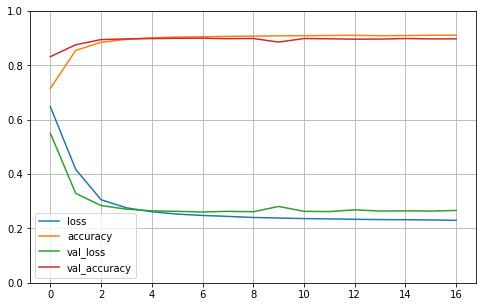

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
dnn.evaluate(X_train_bow, y_train, batch_size=128)

725/725 [==============================] - 4s 5ms/step - loss: 0.3609 - accuracy: 0.8892


[0.3608637750148773, 0.8891571164131165]

In [ ]:
dnn.evaluate(X_test_bow, y_test, batch_size=128)

90/90 [==============================] - 0s 5ms/step - loss: 0.3816 - accuracy: 0.8714


[0.3815677762031555, 0.8713885545730591]

In [ ]:
#train predicted probability
train_proba = dnn.predict(X_train_bow)

#test predicted probability
test_proba = dnn.predict(X_test_bow)

In [ ]:
#predicted classes on train data
y_train_predict = train_proba >0.5

#predicted classes on test data
y_test_predict = test_proba>0.5

In [ ]:
#accuracy score on train data
accuracy_score(y_train,y_train_predict)

0.9132632168796742

In [ ]:
#accuracy score on test data
accuracy_score(y_test,y_test_predict)

0.8984416039222552

In [ ]:
#confusion_matrix on train data

#rows are actual label in ascending order i.e. 0 then 1 and cols are predicted labels
confusion_matrix(y_train, y_train_predict, normalize='true')

array([[0.9240845 , 0.0759155 ],
       [0.09753105, 0.90246895]])

In [ ]:
#confusion_matrix on test data
#rows are actual label in ascending order i.e. 0 then 1 and cols are predicted labels
confusion_matrix(y_test, y_test_predict, normalize='true')

array([[0.91052355, 0.08947645],
       [0.11364034, 0.88635966]])

In [ ]:
from sklearn.metrics import f1_score

#f1_score on the train data
print(f1_score(y_train, y_train_predict))

#f1_score on the test data
print(f1_score(y_test, y_test_predict))

0.9124166222347961
0.8971995746189294


**Observation: Here we are overfittng little bit, certainly we need to tune our model hyperparameters or apply regularization for getting the good performance on the test set as well.**

In [ ]:
#model saving path
model_version = "0001"
model_path = "/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/dnn_bow"

**Saving trained model:**

In [ ]:
import os

In [ ]:
# model_path = os.path.join(model_path, model_version)
# dnn.save(model_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/dnn_bow/0001/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/dnn_bow/0001/assets


**Loading trained data:**

In [ ]:
new_model = tf.keras.models.load_model(model_path)

In [ ]:
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               640128    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 656,769
Trainable params: 656,769
Non-trainable params: 0
_________________________________________________________________


# ML models using TFIDF

## Applying MNB

In [ ]:
mnb = MultinomialNB()

parameters = {'alpha': [0.0001, 0.01, 0.1, 1, 10, 100]}
mnb_tune = GridSearchCV(mnb, parameters, n_jobs=-1, verbose=2)
mnb_tune.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.01, 0.1, 1, 10, 100]}, verbose=2)

In [ ]:
(mnb_tune.cv_results_)

{'mean_fit_time': array([0.09580269, 0.09029818, 0.0940146 , 0.08875203, 0.08732424,
        0.09568624]),
 'mean_score_time': array([0.01321316, 0.01338043, 0.01500187, 0.01332636, 0.01340628,
        0.01566811]),
 'mean_test_score': array([0.88416116, 0.88413198, 0.88416116, 0.88440436, 0.88444328,
        0.87657347]),
 'param_alpha': masked_array(data=[0.0001, 0.01, 0.1, 1, 10, 100],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.0001},
  {'alpha': 0.01},
  {'alpha': 0.1},
  {'alpha': 1},
  {'alpha': 10},
  {'alpha': 100}],
 'rank_test_score': array([3, 5, 4, 2, 1, 6], dtype=int32),
 'split0_test_score': array([0.88390078, 0.88394942, 0.88399805, 0.88438716, 0.8848249 ,
        0.8786965 ]),
 'split1_test_score': array([0.88424125, 0.88424125, 0.88424125, 0.88424125, 0.88336576,
        0.87509728]),
 'split2_test_score': array([0.88506809, 0.88497082, 0.88501946, 0.88550584, 0.88521401,
  

In [ ]:
#mnb with best hyperparameter
best_mnb = mnb_tune.best_estimator_

### Performance of mnb model

In [ ]:
#train predicted probability
train_proba = best_mnb.predict_proba(X_train_tfidf)

#test predicted probability
test_proba = best_mnb.predict_proba(X_test_tfidf)

In [ ]:
#train predicted
y_train_predict = best_mnb.predict(X_train_tfidf)

#test predicted
y_test_predict = best_mnb.predict(X_test_tfidf)

In [ ]:
#accuracy score on the train data
accuracy_score(y_train, y_train_predict)

0.891447304422265

In [ ]:
#accuracy score on the test data
accuracy_score(y_test, y_test_predict)

0.8825949921204693

In [ ]:
#confusion_matrix on train data

#rows are actural label in ascending order i.e. 0 then 1 and cols are predicted labels
confusion_matrix(y_train, y_train_predict, normalize='true')

array([[0.89281893, 0.10718107],
       [0.10992432, 0.89007568]])

In [ ]:
#confusion_matrix on test data
#rows are actual label in ascending order i.e. 0 then 1 and cols are predicted labels
confusion_matrix(y_test, y_test_predict, normalize='true')

array([[0.88513395, 0.11486605],
       [0.11994397, 0.88005603]])

In [ ]:
from sklearn.metrics import f1_score

#f1_score on the train data
print(f1_score(y_train, y_train_predict))

#f1_score on the test data
print(f1_score(y_test, y_test_predict))

0.8912982066493274
0.8822961467567805


**Observation: Performance is good. From confusion matrix, we can say approx 11% of +ve data predicted as -ve and approx 11% of -ve data predicted as +ve on the test data.**

**Saving trained model:**

In [ ]:
# import joblib
joblib.dump(best_mnb, "/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/best_mnb_tfidf.sav")

['/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/best_mnb_tfidf.sav']

**Loading trained data:**

In [ ]:
best_mnb = joblib.load("/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/best_mnb_tfidf.sav")

##Applying Logistic regression

In [ ]:
#max_iter=1000 becoz of high value of C(for small learning rate) below like 100 for converging to minm
lgr = LogisticRegression(max_iter=1000)

parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
lgr_tune = GridSearchCV(lgr, parameters, n_jobs=-1, verbose=2)
lgr_tune.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
             verbose=2)

In [ ]:
(lgr_tune.cv_results_)

{'mean_fit_time': array([ 0.32781391,  0.47545118,  1.16620603,  2.80111904,  6.2583292 ,
        14.14279013, 26.33319416]),
 'mean_score_time': array([0.00792837, 0.00748873, 0.0070787 , 0.00732741, 0.00800815,
        0.00820093, 0.00732212]),
 'mean_test_score': array([0.74056887, 0.82196148, 0.88345102, 0.90241054, 0.89628204,
        0.88508535, 0.87927784]),
 'param_C': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100}],
 'rank_test_score': array([7, 6, 4, 1, 2, 3, 5], dtype=int32),
 'split0_test_score': array([0.74207198, 0.82480545, 0.88526265, 0.90413424, 0.89781128,
        0.88657588, 0.88224708]),
 'split1_test_score': array([0.74032101, 0.82125486, 0.88283074, 0.90038911, 0.89348249,
        0.88098249, 0.87475681]),
 'split2_test_score

In [ ]:
#lgr with best hyperparameter
best_lgr = lgr_tune.best_estimator_

### Performance of lgr model

In [ ]:
#train predicted probability
train_proba = best_lgr.predict_proba(X_train_tfidf)

#test predicted probability
test_proba = best_lgr.predict_proba(X_test_tfidf)

In [ ]:
#train predicted
y_train_predict = best_lgr.predict(X_train_tfidf)

#test predicted
y_test_predict = best_lgr.predict(X_test_tfidf)

In [ ]:
#accuracy score on the train data
accuracy_score(y_train, y_train_predict)

0.9262826125021888

In [ ]:
#accuracy score on the test data
accuracy_score(y_test, y_test_predict)

0.9019436175801085

In [ ]:
#confusion_matrix on train data

#rows are actual label in ascending order i.e. 0 then 1 and cols are predicted labels
confusion_matrix(y_train, y_train_predict, normalize='true')

array([[0.9290064 , 0.0709936 ],
       [0.07644118, 0.92355882]])

In [ ]:
#confusion_matrix on test data
#rows are actual label in ascending order i.e. 0 then 1 and cols are predicted labels
confusion_matrix(y_test, y_test_predict, normalize='true')

array([[0.90684644, 0.09315356],
       [0.1029592 , 0.8970408 ]])

In [ ]:
from sklearn.metrics import f1_score

#f1_score on the train data
print(f1_score(y_train, y_train_predict))

#f1_score on the test data
print(f1_score(y_test, y_test_predict))

0.9260812735324528
0.9014604962167868


**Observation: Performance is fairly better than the knn.**

**Saving trained model:**

In [ ]:
# joblib.dump(best_lgr, "/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/best_lgr_tfidf.sav")

['/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/best_lgr_tfidf.sav']

**Loading trained data:**

In [ ]:
best_lgr = joblib.load("/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/best_lgr_tfidf.sav")

## Applying DNN

In [ ]:
#splitting train data into validation and the train set
X_train_tfidf.sort_indices()
X_test_tfidf.sort_indices()
X_valid_tfidf, X_train_tfidf = X_train_tfidf[:10000], X_train_tfidf[10000:]
y_valid, y_train = y_train[:10000], y_train[10000:]

In [ ]:
#applying simple NN with dropouts
dnn = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(X_train_tfidf.shape[1],), sparse=True),
  tf.keras.layers.Dense(128, activation='elu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='elu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# compile the keras model
dnn.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
history = dnn.fit(X_train_tfidf, y_train, epochs=30, validation_data=(X_valid_tfidf, y_valid), callbacks=[early_stopping_cb])

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_1/dense_3/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_1/dense_3/embedding_lookup_sparse/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_1/dense_3/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


2900/2900 [==============================] - 17s 5ms/step - loss: 0.5851 - accuracy: 0.7576 - val_loss: 0.4222 - val_accuracy: 0.8324
Epoch 2/30
2900/2900 [==============================] - 13s 5ms/step - loss: 0.3334 - accuracy: 0.8665 - val_loss: 0.2859 - val_accuracy: 0.8854
Epoch 3/30
2900/2900 [==============================] - 14s 5ms/step - loss: 0.2585 - accuracy: 0.8957 - val_loss: 0.2560 - val_accuracy: 0.8962
Epoch 4/30
2900/2900 [==============================] - 14s 5ms/step - loss: 0.2314 - accuracy: 0.9077 - val_loss: 0.2445 - val_accuracy: 0.8996
Epoch 5/30
2900/2900 [==============================] - 15s 5ms/step - loss: 0.2166 - accuracy: 0.9140 - val_loss: 0.2370 - val_accuracy: 0.9027
Epoch 6/30
2900/2900 [==============================] - 14s 5ms/step - loss: 0.2068 - accuracy: 0.9186 - val_loss: 0.2342 - val_accuracy: 0.9052
Epoch 7/30
2900/2900 [==============================] - 15s 5ms/step - loss: 0.1993 - accuracy: 0.9219 - val_loss: 0.2351 - val_accuracy: 0.9

### Performance of DNN model

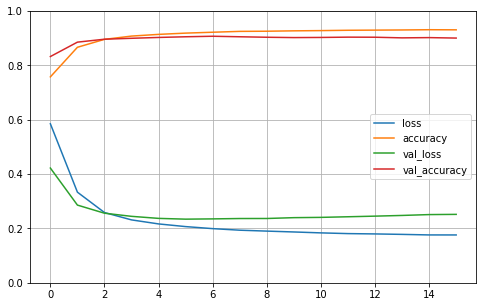

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
dnn.evaluate(X_train_tfidf, y_train, batch_size=128)

725/725 [==============================] - 3s 5ms/step - loss: 0.1893 - accuracy: 0.9270


[0.18927542865276337, 0.9270458221435547]

In [ ]:
dnn.evaluate(X_test_tfidf, y_test, batch_size=128)

90/90 [==============================] - 0s 4ms/step - loss: 0.2398 - accuracy: 0.9049


[0.2398195117712021, 0.9049203395843506]

In [ ]:
#train predicted probability
train_proba = dnn.predict(X_train_tfidf)

#test predicted probability
test_proba = new_model.predict(X_test_tfidf)

In [ ]:
#predicted classes on train data
y_train_predict = train_proba >0.5

#predicted classes on test data
y_test_predict = test_proba>0.5

In [ ]:
#accuracy score on train data
accuracy_score(y_train,y_train_predict)

0.9270458415052049

In [ ]:
#accuracy score on test data
accuracy_score(y_test,y_test_predict)

0.9049203291892839

In [ ]:
#confusion_matrix on train data

#rows are actual label in ascending order i.e. 0 then 1 and cols are predicted labels
confusion_matrix(y_train, y_train_predict, normalize='true')

array([[0.94067888, 0.05932112],
       [0.08655316, 0.91344684]])

In [ ]:
#confusion_matrix on test data
#rows are actual label in ascending order i.e. 0 then 1 and cols are predicted labels
confusion_matrix(y_test, y_test_predict, normalize='true')

array([[0.92120469, 0.07879531],
       [0.11136403, 0.88863597]])

In [ ]:
from sklearn.metrics import f1_score

#f1_score on the train data
print(f1_score(y_train, y_train_predict))

#f1_score on the test data
print(f1_score(y_test, y_test_predict))

0.9261255756094368
0.9033463866144535


**Observation: Here we are overfittng little bit, certainly we need to tune our model hyperparameters or apply regularization for getting the good performance on the test set as well.**

In [ ]:
#model saving path
model_version = "0001"
model_path = "/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/dnn_tfidf"
model_path = os.path.join(model_path, model_version)

**Saving trained model:**

In [ ]:
# dnn.save(model_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/dnn_tfidf/0001/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/dnn_tfidf/0001/assets


**Loading trained data:**

In [ ]:
new_model = tf.keras.models.load_model(model_path)

In [ ]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               1280128   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,296,769
Trainable params: 1,296,769
Non-trainable params: 0
_________________________________________________________________


#ML models using avgW2V

## Applying MNB

In [ ]:
mnb = MultinomialNB()

parameters = {'alpha': [0.0001, 0.01, 0.1, 1, 10, 100]}
mnb_tune = GridSearchCV(mnb, parameters, n_jobs=-1, verbose=2)
mnb_tune.fit(X_train_avgw2v, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.01, 0.1, 1, 10, 100]}, verbose=2)

In [ ]:
(mnb_tune.cv_results_)

{'mean_fit_time': array([0.35344076, 0.25957565, 0.2656179 , 0.25975695, 0.25344849,
        0.25176387]),
 'mean_score_time': array([0.03145719, 0.02983899, 0.02965684, 0.03025484, 0.02936254,
        0.03484812]),
 'mean_test_score': array([0.70683284, 0.70683284, 0.70683284, 0.70681339, 0.70684257,
        0.70648264]),
 'param_alpha': masked_array(data=[0.0001, 0.01, 0.1, 1, 10, 100],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.0001},
  {'alpha': 0.01},
  {'alpha': 0.1},
  {'alpha': 1},
  {'alpha': 10},
  {'alpha': 100}],
 'rank_test_score': array([2, 2, 2, 5, 1, 6], dtype=int32),
 'split0_test_score': array([0.70121595, 0.70121595, 0.70121595, 0.70121595, 0.70126459,
        0.70111868]),
 'split1_test_score': array([0.70787938, 0.70787938, 0.70787938, 0.70787938, 0.70763619,
        0.70787938]),
 'split2_test_score': array([0.70885214, 0.70885214, 0.70885214, 0.70885214, 0.70894942,
  

In [ ]:
#mnb with best hyperparameter
best_mnb = mnb_tune.best_estimator_

### Performance of mnb model

In [ ]:
#train predicted probability
train_proba = best_mnb.predict_proba(X_train_avgw2v)

#test predicted probability
test_proba = best_mnb.predict_proba(X_test_avgw2v)

In [ ]:
#train predicted
y_train_predict = best_mnb.predict(X_train_avgw2v)

#test predicted
y_test_predict = best_mnb.predict(X_test_avgw2v)

In [ ]:
#accuracy score on the train data
accuracy_score(y_train, y_train_predict)

0.7067841786805191

In [ ]:
#accuracy score on the test data
accuracy_score(y_test, y_test_predict)

0.7020661880581335

In [ ]:
#confusion_matrix on train data

#rows are actural label in ascending order i.e. 0 then 1 and cols are predicted labels
confusion_matrix(y_train, y_train_predict, normalize='true')

array([[0.73524777, 0.26475223],
       [0.32167941, 0.67832059]])

In [ ]:
#confusion_matrix on test data
#rows are actual label in ascending order i.e. 0 then 1 and cols are predicted labels
confusion_matrix(y_test, y_test_predict, normalize='true')

array([[0.73104535, 0.26895465],
       [0.32691297, 0.67308703]])

In [ ]:
from sklearn.metrics import f1_score

#f1_score on the train data
print(f1_score(y_train, y_train_predict))

#f1_score on the test data
print(f1_score(y_test, y_test_predict))

0.6981936879205383
0.693174646109458


**Observation: Performance is not good. From confusion matrix, we can say approx 33% of +ve data predicted as -ve and approx 27% of -ve data predicted as +ve on the test data.**

**Saving trained model:**

In [ ]:
# import joblib
joblib.dump(best_mnb, "/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/best_mnb_avgw2v.sav")

['/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/best_mnb_avgw2v.sav']

**Loading trained data:**

In [ ]:
best_mnb = joblib.load("/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/best_mnb_avgw2v.sav")

##Applying Logistic regression

In [ ]:
#max_iter=1000 becoz of high value of C(for small learning rate) below like 100 for converging to minm
lgr = LogisticRegression(max_iter=1000)

parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
lgr_tune = GridSearchCV(lgr, parameters, n_jobs=-1, verbose=2)
lgr_tune.fit(X_train_avgw2v, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
             verbose=2)

In [ ]:
(lgr_tune.cv_results_)

{'mean_fit_time': array([ 2.23878083,  6.11400728, 15.77878051, 29.47286777, 64.26328421,
        93.70981441, 91.09368243]),
 'mean_score_time': array([0.02357597, 0.02222381, 0.02194943, 0.02039104, 0.02068648,
        0.02517805, 0.02590055]),
 'mean_test_score': array([0.71431352, 0.7489056 , 0.78690248, 0.80553125, 0.81106635,
        0.81072588, 0.8106286 ]),
 'param_C': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100}],
 'rank_test_score': array([7, 6, 5, 4, 1, 2, 3], dtype=int32),
 'split0_test_score': array([0.71172179, 0.74815175, 0.78886187, 0.80924125, 0.81624514,
        0.81502918, 0.8151751 ]),
 'split1_test_score': array([0.71410506, 0.74965953, 0.78540856, 0.80223735, 0.80856031,
        0.80821984, 0.80787938]),
 'split2_test_score

In [ ]:
#lgr with best hyperparameter
best_lgr = lgr_tune.best_estimator_

### Performance of lgr model

In [ ]:
#train predicted probability
train_proba = best_lgr.predict_proba(X_train_avgw2v)

#test predicted probability
test_proba = best_lgr.predict_proba(X_test_avgw2v)

In [ ]:
#train predicted
y_train_predict = best_lgr.predict(X_train_avgw2v)

#test predicted
y_test_predict = best_lgr.predict(X_test_avgw2v)

In [ ]:
#accuracy score on the train data
accuracy_score(y_train, y_train_predict)

0.8129632872234869

In [ ]:
#accuracy score on the test data
accuracy_score(y_test, y_test_predict)

0.8110663631588163

In [ ]:
#confusion_matrix on train data

#rows are actual label in ascending order i.e. 0 then 1 and cols are predicted labels
confusion_matrix(y_train, y_train_predict, normalize='true')

array([[0.82178642, 0.17821358],
       [0.19585984, 0.80414016]])

In [ ]:
#confusion_matrix on test data
#rows are actual label in ascending order i.e. 0 then 1 and cols are predicted labels
confusion_matrix(y_test, y_test_predict, normalize='true')

array([[0.8199965 , 0.1800035 ],
       [0.19786377, 0.80213623]])

In [ ]:
from sklearn.metrics import f1_score

#f1_score on the train data
print(f1_score(y_train, y_train_predict))

#f1_score on the test data
print(f1_score(y_test, y_test_predict))

0.8112983482348786
0.8093639575971731


**Observation: Performance is better than the knn but avgw2v performing badly than the tfidf and bow**

**Saving trained model:**

In [ ]:
# joblib.dump(best_lgr, "/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/best_lgr_avgw2v.sav")

['/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/best_lgr_avgw2v.sav']

**Loading trained data:**

In [ ]:
best_lgr = joblib.load("/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/best_lgr_avgw2v.sav")

## Applying DNN

In [ ]:
#splitting train data into validation and the train set
X_valid_avgw2v, X_train_avgw2v = X_train_avgw2v[:10000], X_train_avgw2v[10000:]
y_valid, y_train = y_train[:10000], y_train[10000:]

In [ ]:
#applying simple NN with dropouts
dnn = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(X_train_avgw2v.shape[1],)),
  tf.keras.layers.Dense(128, activation='elu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='elu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# compile the keras model
dnn.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
history = dnn.fit(X_train_avgw2v, y_train, epochs=30, validation_data=(X_valid_avgw2v, y_valid), callbacks=[early_stopping_cb])

Epoch 1/30
2900/2900 [==============================] - 8s 3ms/step - loss: 0.6459 - accuracy: 0.6192 - val_loss: 0.5641 - val_accuracy: 0.7467
Epoch 2/30
2900/2900 [==============================] - 7s 2ms/step - loss: 0.5626 - accuracy: 0.7055 - val_loss: 0.6848 - val_accuracy: 0.5867
Epoch 3/30
2900/2900 [==============================] - 7s 2ms/step - loss: 0.5261 - accuracy: 0.7369 - val_loss: 0.4793 - val_accuracy: 0.7778
Epoch 4/30
2900/2900 [==============================] - 7s 3ms/step - loss: 0.5072 - accuracy: 0.7508 - val_loss: 0.4723 - val_accuracy: 0.7812
Epoch 5/30
2900/2900 [==============================] - 7s 2ms/step - loss: 0.4968 - accuracy: 0.7581 - val_loss: 0.4694 - val_accuracy: 0.7807
Epoch 6/30
2900/2900 [==============================] - 7s 2ms/step - loss: 0.4871 - accuracy: 0.7664 - val_loss: 0.4606 - val_accuracy: 0.7868
Epoch 7/30
2900/2900 [==============================] - 7s 3ms/step - loss: 0.4815 - accuracy: 0.7692 - val_loss: 0.4799 - val_accuracy:

### Performance of DNN model

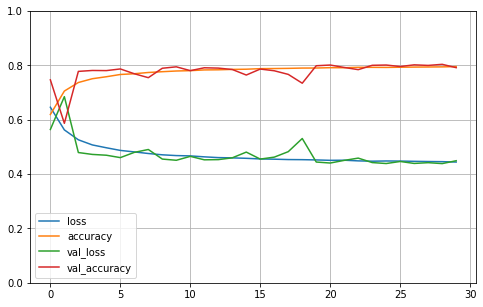

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
dnn.evaluate(X_train_avgw2v, y_train, batch_size=128)

725/725 [==============================] - 2s 2ms/step - loss: 0.4433 - accuracy: 0.7947


[0.44325128197669983, 0.794715404510498]

In [ ]:
dnn.evaluate(X_test_avgw2v, y_test, batch_size=128)

90/90 [==============================] - 0s 2ms/step - loss: 0.4491 - accuracy: 0.7917


[0.4490511417388916, 0.7917177081108093]

In [ ]:
#train predicted probability
train_proba = dnn.predict(X_train_avgw2v)

#test predicted probability
test_proba = dnn.predict(X_test_avgw2v)

In [ ]:
#predicted classes on train data
y_train_predict = train_proba >0.5

#predicted classes on test data
y_test_predict = test_proba>0.5

In [ ]:
#accuracy score on train data
accuracy_score(y_train,y_train_predict)

0.7947154033492101

In [ ]:
#accuracy score on test data
accuracy_score(y_test,y_test_predict)

0.7917177376991771

In [ ]:
#confusion_matrix on train data

#rows are actual label in ascending order i.e. 0 then 1 and cols are predicted labels
confusion_matrix(y_train, y_train_predict, normalize='true')

array([[0.88448674, 0.11551326],
       [0.29483178, 0.70516822]])

In [ ]:
#confusion_matrix on test data
#rows are actual label in ascending order i.e. 0 then 1 and cols are predicted labels
confusion_matrix(y_test, y_test_predict, normalize='true')

array([[0.88478375, 0.11521625],
       [0.30134828, 0.69865172]])

In [ ]:
from sklearn.metrics import f1_score

#f1_score on the train data
print(f1_score(y_train, y_train_predict))

#f1_score on the test data
print(f1_score(y_test, y_test_predict))

0.7747428166016318
0.770344627859832


**Observation: Look at above confusion matrix: approx 30% of +ve data predicted as -ve and 11% of -ve data predicted as +ve. And also overall performance is not good. It is performing badly than the bow and tfidf vectorization.**

In [ ]:
#model saving path
model_version = "0001"
model_path = "/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/dnn_avgw2v"
model_path = os.path.join(model_path, model_version)

**Saving trained model:**

In [ ]:
# dnn.save(model_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/dnn_avgw2v/0001/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/dnn_avgw2v/0001/assets


**Loading trained data:**

In [ ]:
new_model = tf.keras.models.load_model(model_path)

In [ ]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               1280128   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,296,769
Trainable params: 1,296,769
Non-trainable params: 0
_________________________________________________________________


#ML models using TFIDF-W2V

## Applying MNB

In [ ]:
mnb = MultinomialNB()

parameters = {'alpha': [0.0001, 0.01, 0.1, 1, 10, 100]}
mnb_tune = GridSearchCV(mnb, parameters, n_jobs=-1, verbose=2)
mnb_tune.fit(X_train_tfidfw2v, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.01, 0.1, 1, 10, 100]}, verbose=2)

In [ ]:
(mnb_tune.cv_results_)

{'mean_fit_time': array([0.28046093, 0.24176316, 0.24509745, 0.25405831, 0.25565338,
        0.25174341]),
 'mean_score_time': array([0.02965622, 0.03388381, 0.02925968, 0.03023195, 0.02958674,
        0.02929196]),
 'mean_test_score': array([0.68671572, 0.68671572, 0.68671572, 0.68671572, 0.6867449 ,
        0.68645306]),
 'param_alpha': masked_array(data=[0.0001, 0.01, 0.1, 1, 10, 100],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.0001},
  {'alpha': 0.01},
  {'alpha': 0.1},
  {'alpha': 1},
  {'alpha': 10},
  {'alpha': 100}],
 'rank_test_score': array([2, 2, 2, 2, 1, 6], dtype=int32),
 'split0_test_score': array([0.68146887, 0.68146887, 0.68146887, 0.68146887, 0.68161479,
        0.6813716 ]),
 'split1_test_score': array([0.68895914, 0.68895914, 0.68895914, 0.68895914, 0.68895914,
        0.6885214 ]),
 'split2_test_score': array([0.68745136, 0.68745136, 0.68745136, 0.68745136, 0.68745136,
  

In [ ]:
#mnb with best hyperparameter
best_mnb = mnb_tune.best_estimator_

### Performance of mnb model

In [ ]:
#train predicted probability
train_proba = best_mnb.predict_proba(X_train_tfidfw2v)

#test predicted probability
test_proba = best_mnb.predict_proba(X_test_tfidfw2v)

In [ ]:
#train predicted
y_train_predict = best_mnb.predict(X_train_tfidfw2v)

#test predicted
y_test_predict = best_mnb.predict(X_test_tfidfw2v)

In [ ]:
#accuracy score on the train data
accuracy_score(y_train, y_train_predict)

0.686657327963579

In [ ]:
#accuracy score on the test data
accuracy_score(y_test, y_test_predict)

0.6622307827000525

In [ ]:
#confusion_matrix on train data

#rows are actural label in ascending order i.e. 0 then 1 and cols are predicted labels
confusion_matrix(y_train, y_train_predict, normalize='true')

array([[0.71799062, 0.28200938],
       [0.34467597, 0.65532403]])

In [ ]:
#confusion_matrix on test data
#rows are actual label in ascending order i.e. 0 then 1 and cols are predicted labels
confusion_matrix(y_test, y_test_predict, normalize='true')

array([[0.8966906 , 0.1033094 ],
       [0.57222903, 0.42777097]])

In [ ]:
from sklearn.metrics import f1_score

#f1_score on the train data
print(f1_score(y_train, y_train_predict))

#f1_score on the test data
print(f1_score(y_test, y_test_predict))

0.6765216867348885
0.558783165599268


**Observation: Our model badly performing. From confusion matrix, we can say approx 57% of +ve data predicted as -ve and only approx 10% of -ve data predicted as +ve on the test data.**

**Saving trained model:**

In [ ]:
# import joblib
joblib.dump(best_mnb, "/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/best_mnb_tfidfw2v.sav")

['/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/best_mnb_tfidfw2v.sav']

**Loading trained data:**

In [ ]:
best_mnb = joblib.load("/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/best_mnb_tfidfw2v.sav")

##Applying Logistic regression

In [ ]:
#max_iter=1000 becoz of high value of C(for small learning rate) below like 100 for converging to minm
lgr = LogisticRegression(max_iter=1000)

parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
lgr_tune = GridSearchCV(lgr, parameters, n_jobs=-1, verbose=2)
lgr_tune.fit(X_train_tfidfw2v, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
             verbose=2)

In [ ]:
(lgr_tune.cv_results_)

{'mean_fit_time': array([ 1.69686179,  4.29536023, 13.67927008, 26.22403564, 45.35247846,
        39.27530909, 30.27579355]),
 'mean_score_time': array([0.01774206, 0.01883359, 0.01647735, 0.01823759, 0.01749249,
        0.01914263, 0.01654243]),
 'mean_test_score': array([0.69548048, 0.73742681, 0.77271931, 0.78893559, 0.79141618,
        0.79112434, 0.79102706]),
 'param_C': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100}],
 'rank_test_score': array([7, 6, 5, 4, 1, 2, 3], dtype=int32),
 'split0_test_score': array([0.69187743, 0.73818093, 0.77490272, 0.79396887, 0.79688716,
        0.79625486, 0.79635214]),
 'split1_test_score': array([0.6963035 , 0.7338035 , 0.77008755, 0.78560311, 0.79002918,
        0.79032101, 0.7905642 ]),
 'split2_test_score

In [ ]:
#lgr with best hyperparameter
best_lgr = lgr_tune.best_estimator_

### Performance of lgr model

In [ ]:
#train predicted probability
train_proba = best_lgr.predict_proba(X_train_tfidfw2v)

#test predicted probability
test_proba = best_lgr.predict_proba(X_test_tfidfw2v)

In [ ]:
#train predicted
y_train_predict = best_lgr.predict(X_train_tfidfw2v)

#test predicted
y_test_predict = best_lgr.predict(X_test_tfidfw2v)

In [ ]:
#accuracy score on the train data
accuracy_score(y_train, y_train_predict)

0.7934687445281037

In [ ]:
#accuracy score on the test data
accuracy_score(y_test, y_test_predict)

0.8043249868674488

In [ ]:
#confusion_matrix on train data

#rows are actual label in ascending order i.e. 0 then 1 and cols are predicted labels
confusion_matrix(y_train, y_train_predict, normalize='true')

array([[0.80091052, 0.19908948],
       [0.21397303, 0.78602697]])

In [ ]:
#confusion_matrix on test data
#rows are actual label in ascending order i.e. 0 then 1 and cols are predicted labels
confusion_matrix(y_test, y_test_predict, normalize='true')

array([[0.8203467 , 0.1796533 ],
       [0.21169673, 0.78830327]])

In [ ]:
from sklearn.metrics import f1_score

#f1_score on the train data
print(f1_score(y_train, y_train_predict))

#f1_score on the test data
print(f1_score(y_test, y_test_predict))

0.7919202610919996
0.8011388913604414


**Observation: Look at above confusion matrix: approx 21% of +ve data predicted as -ve and 17% of -ve data predicted as +ve. And also overall performance is not very good. It is performing badly than the bow and tfidf vectorization but better than the avgw2v.**

**Saving trained model:**

In [ ]:
# joblib.dump(best_lgr, "/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/best_lgr_tfidfw2v.sav")

['/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/best_lgr_tfidfw2v.sav']

**Loading trained data:**

In [ ]:
best_lgr = joblib.load("/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/best_lgr_tfidfw2v.sav")

## Applying DNN

In [ ]:
#splitting train data into validation and the train set
X_valid_tfidfw2v, X_train_tfidfw2v = X_train_tfidfw2v[:10000], X_train_tfidfw2v[10000:]
y_valid, y_train = y_train[:10000], y_train[10000:]

In [ ]:
#applying simple NN with dropouts
dnn = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(X_train_tfidfw2v.shape[1],)),
  tf.keras.layers.Dense(128, activation='elu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='elu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# compile the keras model
dnn.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
history = dnn.fit(X_train_tfidfw2v, y_train, epochs=30, validation_data=(X_valid_tfidfw2v, y_valid), callbacks=[early_stopping_cb])

Epoch 1/30
2900/2900 [==============================] - 7s 2ms/step - loss: 0.6449 - accuracy: 0.6230 - val_loss: 0.6091 - val_accuracy: 0.6435
Epoch 2/30
2900/2900 [==============================] - 7s 2ms/step - loss: 0.5706 - accuracy: 0.7017 - val_loss: 0.5249 - val_accuracy: 0.7495
Epoch 3/30
2900/2900 [==============================] - 6s 2ms/step - loss: 0.5359 - accuracy: 0.7309 - val_loss: 0.5616 - val_accuracy: 0.7056
Epoch 4/30
2900/2900 [==============================] - 6s 2ms/step - loss: 0.5226 - accuracy: 0.7413 - val_loss: 0.5122 - val_accuracy: 0.7499
Epoch 5/30
2900/2900 [==============================] - 7s 2ms/step - loss: 0.5111 - accuracy: 0.7471 - val_loss: 0.4865 - val_accuracy: 0.7742
Epoch 6/30
2900/2900 [==============================] - 6s 2ms/step - loss: 0.5046 - accuracy: 0.7545 - val_loss: 0.4998 - val_accuracy: 0.7602
Epoch 7/30
2900/2900 [==============================] - 6s 2ms/step - loss: 0.4974 - accuracy: 0.7590 - val_loss: 0.4842 - val_accuracy:

### Performance of DNN model

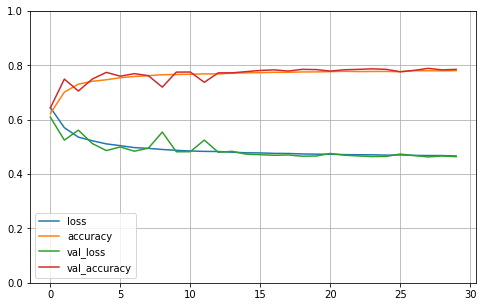

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
dnn.evaluate(X_train_tfidfw2v, y_train, batch_size=128)

725/725 [==============================] - 1s 2ms/step - loss: 0.4568 - accuracy: 0.7880


[0.4568363428115845, 0.7879911065101624]

In [ ]:
dnn.evaluate(X_test_tfidfw2v, y_test, batch_size=128)

90/90 [==============================] - 0s 2ms/step - loss: 0.4598 - accuracy: 0.7972


[0.4597606062889099, 0.7972334027290344]

In [ ]:
#train predicted probability
train_proba = dnn.predict(X_train_tfidfw2v)

#test predicted probability
test_proba = dnn.predict(X_test_tfidfw2v)

In [ ]:
#predicted classes on train data
y_train_predict = train_proba >0.5

#predicted classes on test data
y_test_predict = test_proba>0.5

In [ ]:
#accuracy score on train data
accuracy_score(y_train,y_train_predict)

0.7879911204982866

In [ ]:
#accuracy score on test data
accuracy_score(y_test,y_test_predict)

0.797233409210296

In [ ]:
#confusion_matrix on train data

#rows are actual label in ascending order i.e. 0 then 1 and cols are predicted labels
confusion_matrix(y_train, y_train_predict, normalize='true')

array([[0.83386202, 0.16613798],
       [0.25776525, 0.74223475]])

In [ ]:
#confusion_matrix on test data
#rows are actual label in ascending order i.e. 0 then 1 and cols are predicted labels
confusion_matrix(y_test, y_test_predict, normalize='true')

array([[0.86657328, 0.13342672],
       [0.27210646, 0.72789354]])

In [ ]:
from sklearn.metrics import f1_score

#f1_score on the train data
print(f1_score(y_train, y_train_predict))

#f1_score on the test data
print(f1_score(y_test, y_test_predict))

0.7780410207811548
0.7821260583254938


**Observation: Look at above confusion matrix: approx 25% of +ve data predicted as -ve and 13% of -ve data predicted as +ve. And also overall performance is not very good. It is performing badly than the bow and tfidf vectorization.**

In [ ]:
#model saving path
model_version = "0001"
model_path = "/content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/dnn_tfidfw2v"
model_path = os.path.join(model_path, model_version)

**Saving trained model:**

In [ ]:
# dnn.save(model_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/applied ai/myself work/amazon fine food reviews/saved_models/dnn_tfidfw2v/0001/assets


**Loading trained data:**

In [ ]:
new_model = tf.keras.models.load_model(model_path)

In [ ]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               38528     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 55,169
Trainable params: 55,169
Non-trainable params: 0
_________________________________________________________________


#Conclusion:

**Logistic regression with the bow vectorization gives us the best performance with approx 91% train accuracy and approx 90% test accuracy.**

**The End**